In [21]:
from scipy.stats import skew, kurtosis
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
import pandas as pd
from scipy.stats import entropy
import math
import keras

In [22]:
def entropy1(labels, base=None):
  value,counts = np.unique(labels, return_counts=True)
  return entropy(counts, base=base)

In [23]:
df = pd.read_csv("./data/icici_04-18_clean.csv")
df = df['Close'][0:-2].values

In [24]:
train = df[0: int(math.floor(0.75 * len(df)))]
valid = df[int(math.floor(0.75 * len(df))):]

In [25]:
print(df.shape)

(3549,)


In [26]:
print(train.shape, valid.shape)

(2661,) (888,)


In [27]:
x_train, y_train = [], []
for i in range(7,len(train)):
    x_train.append(train[i-7:i])
    y_train.append(train[i])
x_train, y_train = np.array(x_train), np.array(y_train)

In [28]:
y_train.shape

(2654,)

In [29]:
inputs = df[len(train) - 7:]
x_test = []

for i in range(7,inputs.shape[0]):
    x_test.append(inputs[i-7:i])
x_test = np.array(x_test)
print(x_test.shape)

(888, 7)


In [30]:
a = x_train
Feature_array = []
for row in range(0,a.shape[0]):
    mean = np.mean(a[row])
    f = np.array([mean])
    skewness = skew(a[row], axis=0, bias=True)
    f = np.append(f, skewness)
    kurt = kurtosis(a[row], axis=0, fisher=True, bias=True)
    f= np.append(f, kurt)
    variance = np.var(a[row])
    f = np.append(f, variance)
    std = np.std(a[row])
    f = np.append(f, std)
    x = np.arange(0,len(a[row]),1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,a[row])
    f = np.append(f, slope)
    f = np.append(f, entropy1(a[row]))
    df = pd.DataFrame({'A' : a[row]})
    f = np.append(f,df.ewm(alpha = 0.6).mean().iloc[-1,0])
    Feature_array.append(f)
    
Feature_train = np.asarray(Feature_array)

a = x_test
Feature_array = []
for row in range(0,a.shape[0]):
    mean = np.mean(a[row])
    f = np.array([mean])
    skewness = skew(a[row], axis=0, bias=True)
    f = np.append(f, skewness)
    kurt = kurtosis(a[row], axis=0, fisher=True, bias=True)
    f= np.append(f, kurt)
    variance = np.var(a[row])
    f = np.append(f, variance)
    std = np.std(a[row])
    f = np.append(f, std)
    x = np.arange(0,len(a[row]),1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,a[row])
    f = np.append(f, slope)
    f = np.append(f, entropy1(a[row]))
    df = pd.DataFrame({'A' : a[row]})
    f = np.append(f,df.ewm(alpha = 0.6).mean().iloc[-1,0])
    Feature_array.append(f)
    
Feature_test = np.asarray(Feature_array)

In [33]:
# x_train = np.reshape(Feature_train, (Feature_train.shape[0],Feature_train.shape[1]))
# x_test = np.reshape(Feature_test, (Feature_test.shape[0],Feature_test.shape[1]))

print(x_train.shape)
# create and fit the LSTM network
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=128, activation='relu',input_dim=x_train.shape[1]))
model.add(keras.layers.Dense(units=64, activation='relu'))
model.add(keras.layers.Dense(units=32, activation='relu'))
model.add(keras.layers.Dense(units=16, activation='relu'))
model.add(keras.layers.Dense(1))
model.summary()
model.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam())
model.fit(x_train, y_train, epochs=100, batch_size=8, verbose=1, validation_data=(x_test, valid) )


(2654, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 128)               1152      
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_23 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 17        
Total params: 12,033
Trainable params: 12,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2654/2654 [==============================] - 1s 434us/step - loss: 3936.8850
Epoch 2/100
2654/2654 [================

2654/2654 [==============================] - 1s 272us/step - loss: 23.5377
Epoch 83/100
2654/2654 [==============================] - 1s 268us/step - loss: 22.0043
Epoch 84/100
2654/2654 [==============================] - 1s 264us/step - loss: 25.1938
Epoch 85/100
2654/2654 [==============================] - 1s 265us/step - loss: 23.9724
Epoch 86/100
2654/2654 [==============================] - 1s 277us/step - loss: 22.8042
Epoch 87/100
2654/2654 [==============================] - 1s 265us/step - loss: 21.2101
Epoch 88/100
2654/2654 [==============================] - 1s 266us/step - loss: 21.6006
Epoch 89/100
2654/2654 [==============================] - 1s 268us/step - loss: 22.4238
Epoch 90/100
2654/2654 [==============================] - 1s 262us/step - loss: 22.3560
Epoch 91/100
2654/2654 [==============================] - 1s 268us/step - loss: 23.1990
Epoch 92/100
2654/2654 [==============================] - 1s 266us/step - loss: 22.4289
Epoch 93/100
2654/2654 [=====================

In [34]:
closing_price = model.predict(x_test)
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
print(rms)

66.0833717861


In [35]:
valid.shape

(888,)

# Train Accuracy and plot

In [51]:
# # Best Model
# # model.load_weights(filepath)
# score = model.evaluate(x_test, valid, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

IndexError: invalid index to scalar variable.

In [48]:
import seaborn as sns
sns.set(font_scale = 1.8)

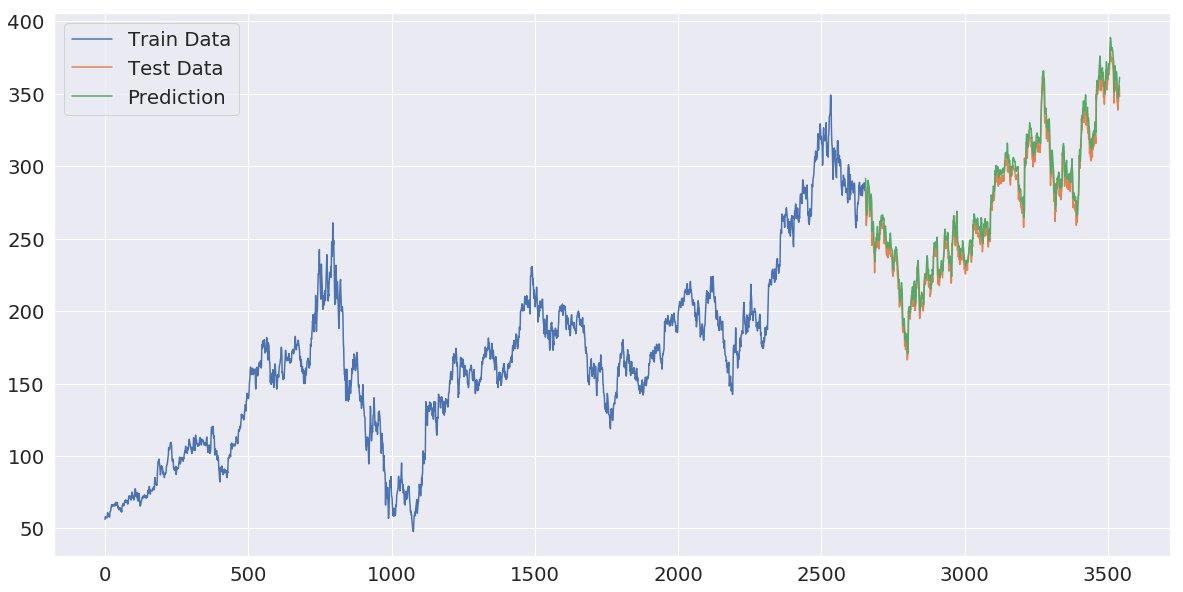

In [49]:
train = y_train
closing_price_x = np.arange(len(y_train), len(y_train) + len(closing_price), 1)
valid_x = np.arange(len(y_train), len(y_train) + len(valid), 1)
plt.figure(figsize=(20,10))
plt.plot(train, label = 'Train Data')
plt.plot(valid_x, valid, label = 'Test Data')
plt.plot(closing_price_x, closing_price, label = 'Prediction')
plt.legend()
plt.show()

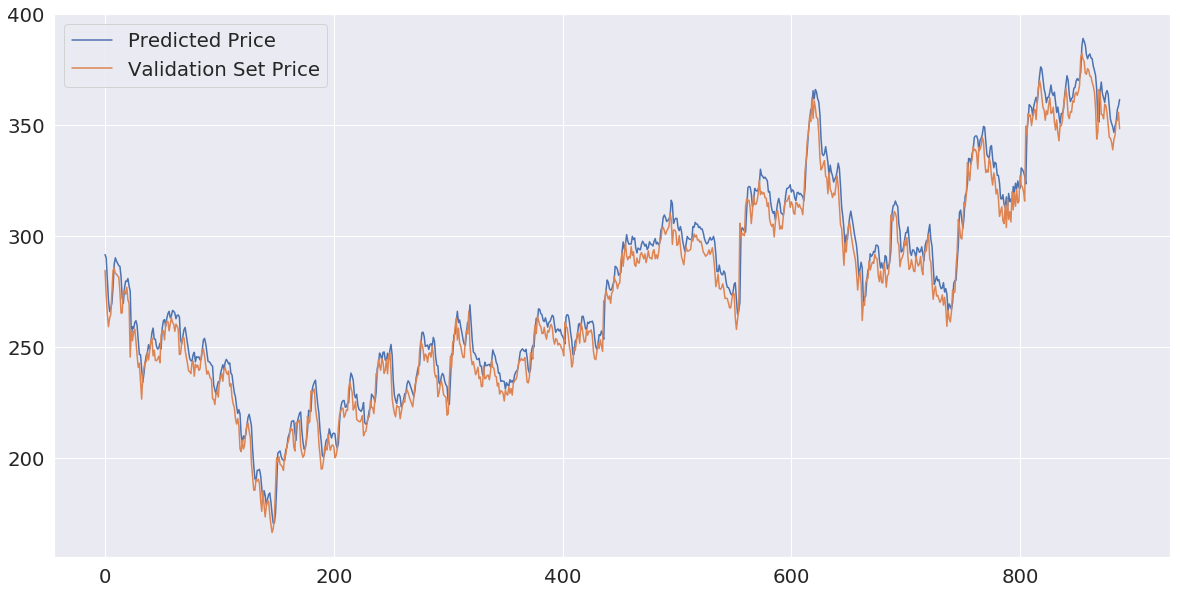

In [50]:
# y_pred = model.predict(x_train)
plt.figure(figsize=(20,10))
plt.plot(closing_price.ravel(), label = 'Predicted Price')
plt.plot(valid.ravel(), label = 'Validation Set Price')
plt.legend()